In [12]:
import opendp.prelude as dp
dp.enable_features("contrib")
import numpy as np
import math
from scipy.spatial import ConvexHull
from scipy.stats import norm
from scipy.special import logsumexp
from dp_accounting.pld.pld_pmf import create_pmf_pessimistic_connect_dots_fixed_gap
from _utils import *
from _privacy_lib import *
import matplotlib.pyplot as plt
import copy

In [2]:
#randomly generate epsilons uniformly and sort them
epsilons = np.random.uniform(low = 0.01, high = 1, size = 100)
epsilons.sort()

#get deltas from Gaussian mechanism

input_space = dp.atom_domain(T=float), dp.absolute_distance(T=float)
meas_approxDP = dp.c.make_zCDP_to_approxDP(input_space >> dp.m.then_base_gaussian(scale=1.9))
curve = meas_approxDP.map(1.)
def find_delta(eps, curve, iter):
    return dp.binary_search(
        lambda delta: curve.epsilon(delta=delta) >= eps,
        bounds=(1e-15, 1.))
deltas = np.zeros(len(epsilons))
for i in range(len(epsilons)):
    delta = find_delta(epsilons[i], curve, 100000)
    deltas[i] = delta

#stack epsilons and deltas
points = np.vstack((epsilons, deltas)).T

# #get lower Convex Hull
lower_curve = get_lower(copy.deepcopy(points))

#assert that the deltas are non-increasing
#if this fails, just run again. It means we got unlucky
#with the noise I add to the deltas
if np.any(np.diff(lower_curve[:,1]) > 0):
  raise ValueError(f'Deltas increase at some point! '
                   f'Recall that this code adds noise to delta to '
                   f'form an invalid privacy curve. This error is likely due to'
                   f'too much noise being added. Rerun this block of code and this error should go away. ')

In [97]:
import copy
lower_curve = get_lower(copy.deepcopy(points))
# lower_curve_1 = get_lower_general(copy.deepcopy(points))

In [3]:
discretization = 0.005
rounded_epsilon_lower, rounded_epsilon_upper,  ctd_deltas = sample_evenly_on_convex_hull(lower_curve, discretization)

ctd_epsilons = np.arange(rounded_epsilon_lower, rounded_epsilon_upper + 1) * discretization

Text(0.5, 1.0, 'Privacy Curve $\\epsilon-\\delta$')

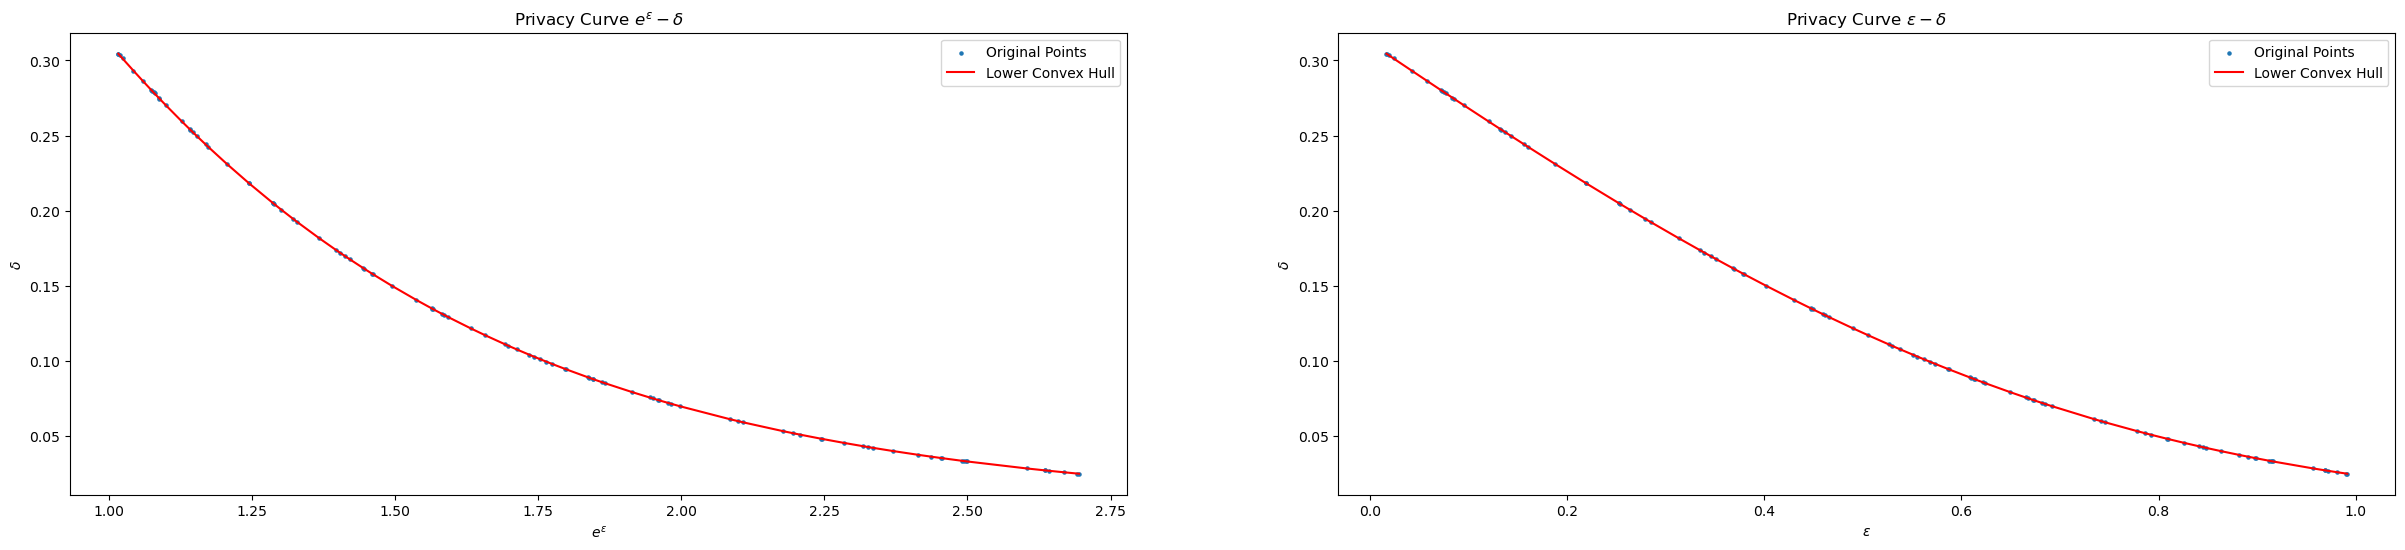

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (30,6), dpi = 100)
ax[0].scatter(np.exp(epsilons), deltas, s = 5, label = 'Original Points')
ax[0].plot(np.exp(lower_curve[:,0]), lower_curve[:,1], c = 'r', label = 'Lower Convex Hull')
ax[0].legend();ax[0].set_xlabel('$e^\epsilon$'); ax[0].set_ylabel('$\delta$'); #ax[0].set_xscale('exp');
ax[0].set_title('Privacy Curve '+'$e^\epsilon-\delta$')

ax[1].scatter(epsilons, deltas, s = 5, label = 'Original Points')
ax[1].plot(lower_curve[:,0], lower_curve[:,1], c = 'r', label = 'Lower Convex Hull')
ax[1].legend();ax[1].set_xlabel('$\epsilon$'); ax[1].set_ylabel('$\delta$'); #ax[0].set_xscale('exp');
ax[1].set_title('Privacy Curve '+'$\epsilon-\delta$')

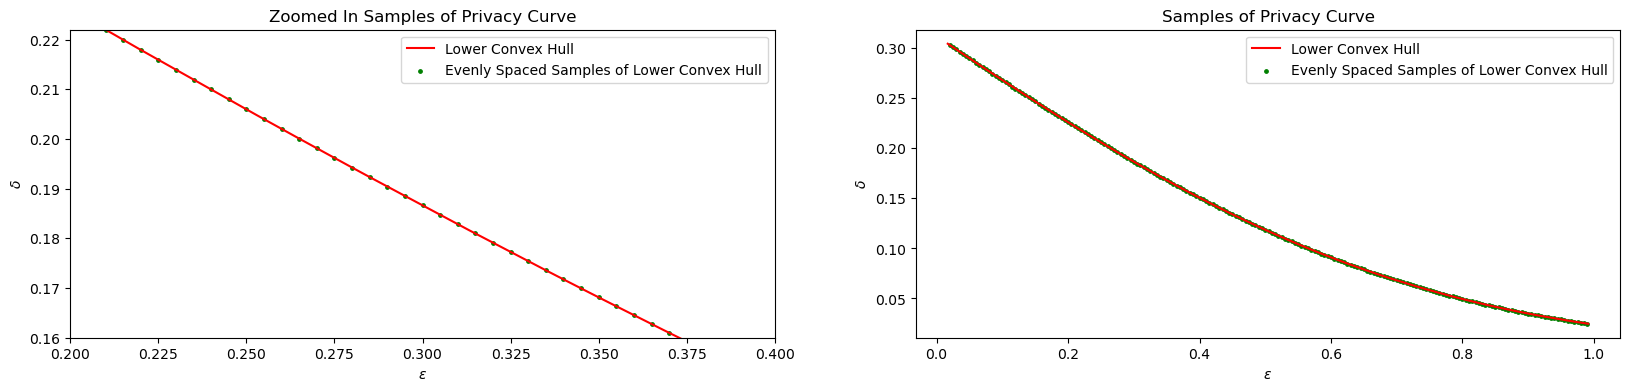

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (20,4), dpi = 100)

ax[1].plot(lower_curve[:,0], lower_curve[:,1], c = 'r', label = 'Lower Convex Hull')
ax[1].scatter(ctd_epsilons, ctd_deltas, c = 'g', s = 6, label = 'Evenly Spaced Samples of Lower Convex Hull')
ax[1].legend(); ax[1].set_xlabel('$\epsilon$'); ax[1].set_ylabel('$\delta$'); #plt.yscale('log');
ax[1].set_title('Samples of Privacy Curve')

ax[0].plot(lower_curve[:,0], lower_curve[:,1], c = 'r', label = 'Lower Convex Hull')
ax[0].scatter(ctd_epsilons, ctd_deltas, c = 'g', s = 6, label = 'Evenly Spaced Samples of Lower Convex Hull')
ax[0].legend(); ax[0].set_xlabel('$\epsilon$'); ax[0].set_ylabel('$\delta$'); #plt.yscale('log');
ax[0].set_xlim([0.2,0.4]); ax[0].set_ylim([0.16,0.222])
ax[0].set_title('Zoomed In Samples of Privacy Curve');

# Accounting with FFT

In [7]:
#create DensePLDPmf or SparsePLDPmf using Connect the Dots function:
pld = create_pmf_pessimistic_connect_dots_fixed_gap(
    discretization = discretization,
    rounded_epsilon_lower = rounded_epsilon_lower,
    rounded_epsilon_upper = rounded_epsilon_upper,
    deltas = ctd_deltas
    )

#convolve and account!
comps = 10
composed_pld = pld.self_compose(comps)

#create eps grid
eps_array = np.linspace(0.1,3.5, 100)
deltas_ctd = composed_pld.get_delta_for_epsilon(eps_array)

# Accounting with SPA

In [9]:
#get support and pmf values of the PLD. Note that
#this PLD has a finite chance of being infinity.
grid, probs, inf_mass = get_pld_for_spa(lower_curve)
#assert that probabilities sum to 1
assert np.isclose(1 - sum(probs) - inf_mass,  np.finfo(float).eps)

#rum the SPA code
prv = CTD_Mechanism(sampling_probability = 1.0, grid = grid, probs = probs, inf_mass = inf_mass)
spa = SaddlePointAccountant(prv)

comps = 10
inf_mass_comp = -math.expm1(comps * math.log1p(-inf_mass))
9
delta_constant = 1 - inf_mass_comp
delta_inf_constant = inf_mass_comp


#run the SPA Accountant to get the delta and corresponding delta error
deltas_err_clt = np.array([spa.compute_delta_clt(epsilon = eps, compositions = comps) for eps in eps_array] )

#Note that delta_total = delta_spa * Pr(PLD finite) + 1 * Pr(PLD infinite)
#since the SPA Accountant computes delta conditioned on the PLD being finite.
#the below code adds the probability of infinity to delta
deltas_clt_upper = (deltas_err_clt[:,0] + deltas_err_clt[:,1] ) * delta_constant + delta_inf_constant
deltas_clt_mid = (deltas_err_clt[:,0]) * delta_constant + delta_inf_constant
deltas_clt_lower = (deltas_err_clt[:,0] - deltas_err_clt[:,1] ) * delta_constant + delta_inf_constant

#Run the Moments accountant for comparisions to the SPA error
deltas_ma_L_finite = np.array([ compute_delta_moments_accountant(prv, eps, comps) for eps in eps_array])
deltas_ma = deltas_ma_L_finite * delta_constant + delta_inf_constant

# Results

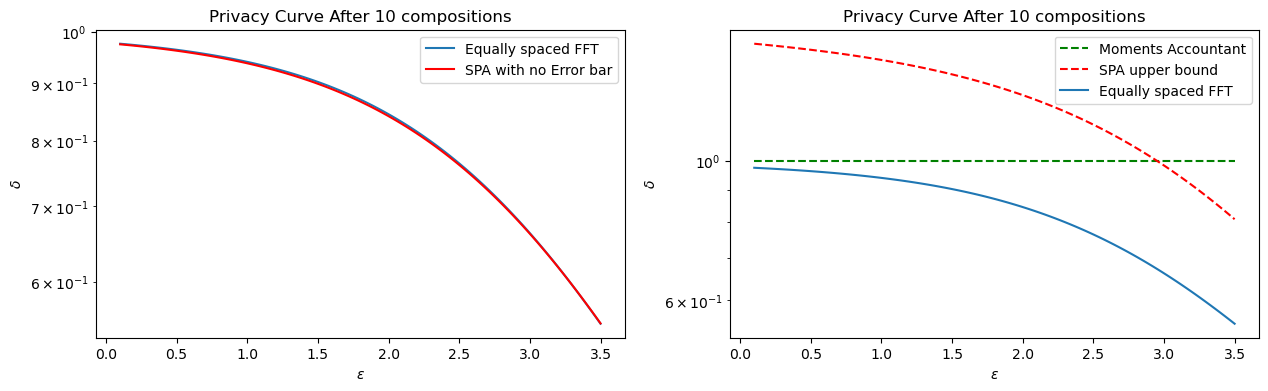

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize = (15,4), dpi = 100)
ax[0].plot(eps_array, deltas_ctd, label = 'Equally spaced FFT')
ax[0].plot(eps_array, deltas_clt_mid, c = 'r', label = 'SPA with no Error bar')
ax[0].legend();ax[0].set_xlabel('$\epsilon$'); ax[0].set_ylabel('$\delta$'); ax[0].set_yscale('log');
ax[0].set_title(f'Privacy Curve After {comps} compositions')


ax[1].plot(eps_array, deltas_ma, '--g', label = 'Moments Accountant')
ax[1].plot(eps_array, deltas_clt_upper, '--r', label = 'SPA upper bound')
# ax[1].plot(eps_array, deltas_clt_lower, '--r') #this is the SPA lower bound
ax[1].plot(eps_array, deltas_ctd, label = 'Equally spaced FFT')
ax[1].legend();ax[1].set_xlabel('$\epsilon$'); ax[1].set_ylabel('$\delta$'); ax[1].set_yscale('log');
ax[1].set_title(f'Privacy Curve After {comps} compositions');